<a href="https://colab.research.google.com/github/lingchm/datascience/blob/master/exercises/signal_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of Defective Parts using FPCA

*fpca*, *high-dimensional data*, *signals*

**Problem**

In a press machine the load profiles are measured during the forging process. The goal is to predict the quality of produced product based on the load profiles.

There are 200 profiles along with their quality labels. 100 non-defective and 100 defective parts. For a new curve, we want to decide if it is a defective or non-defective part. 

**Method**

Each sample is highly-dimensional signal recorded over 1s. Thus, we need to do dimension reduction. We use two methods:
* Option 1: B-spline coefficients
* Option 2: Functional principal components
as inputs to a classification model trained using SVM. 

**Results**

Both methods achieved correctly classified all 100 new samples. FPCA uses a smaller reduced dimension than B-splines and is more interpretable in terms of visualizing where the two classes are different.

**References**

Credits to Dr. Kamran Paynabar for this demo. 

In [14]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 E261
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.spatial import distance_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
from scipy.interpolate import splrep
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.interpolate import BSpline
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

In [16]:
import warnings
warnings.filterwarnings('ignore')

## Generating simulation data

In [4]:
# Data generation
M = 100
n = 50
x = np.linspace(0, 1, n)
E = distance_matrix(x[:, None], x[:, None])
Sigma = np.exp(-10*E**2)
eig_vals, eig_vecs = np.linalg.eigh(Sigma)
Sigma_sqrt = eig_vecs@np.diag((eig_vals+1e-8)**0.5)@eig_vecs.T
S_noise = np.exp(-0.1*E**2)
noise_eval, noise_evec = np.linalg.eigh(S_noise)
S_sqrt_noise = noise_evec@np.diag((noise_eval+1e-8)**0.5)@noise_evec.T

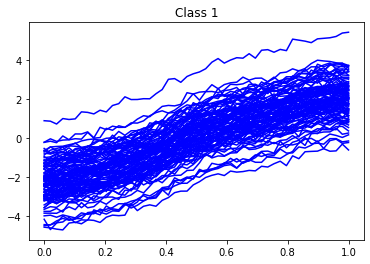

In [5]:
# Class 1
mean1 = Sigma_sqrt@np.random.normal(size=n)
noise1 = S_sqrt_noise@np.random.normal(size=n)
signal1 = mean1 + noise1
var1 = np.var(signal1)
ds1 = (var1/100)**0.5
S_sqrt_err1 = np.eye(n)*ds1
x1 = []
for i in range(M):
    noise1 = S_sqrt_noise@np.random.normal(size=n)
    error1 = S_sqrt_err1@np.random.normal(size=n)
    x1.append(mean1+noise1+error1)
x1 = np.vstack(x1)
plt.plot(x, x1.T, 'b')
plt.title('Class 1')
plt.show()

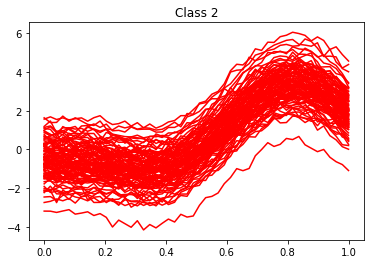

In [7]:
# Class 2
mean2 = Sigma_sqrt.dot(np.random.normal(size=n))
noise2 = S_sqrt_noise.dot(np.random.normal(size=n))
signal2 = mean2 + noise2
var2 = np.var(signal2)
ds2 = (var2/100)**0.5
S_sqrt_err2 = np.eye(n)*ds2
x2 = []
for i in range(M):
    noise2 = S_sqrt_noise@np.random.normal(size=n)
    error2 = S_sqrt_err2@np.random.normal(size=n)
    x2.append(mean2+noise2+error2)
x2 = np.vstack(x2)
plt.plot(x, x2.T, 'r')
plt.title('Class 2')
plt.show()

In [8]:
# Train and test data sets
X = np.vstack([x1, x2])
lab = np.ones(2*M)
lab[:M] = 0
indices = np.arange(2*M)
X_trg, X_tst, Y_trg, Y_tst, i_trg, i_tst = train_test_split(
    X, lab, indices, train_size=0.8)


## Option 1: B-splines

In [10]:
# B-SPLINES
def BSplineBasis(x: np.array, knots: np.array, degree: int) -> np.array:
    '''Return B-Spline basis. Python equivalent to bs in R or the spmak/spval combination in MATLAB.
    This function acts like the R command bs(x,knots=knots,degree=degree, intercept=False)
    Arguments:
        x: Points to evaluate spline on, sorted increasing
        knots: Spline knots, sorted increasing
        degree: Spline degree. 
    Returns:
        B: Array of shape (x.shape[0], len(knots)+degree+1). 
    Note that a spline has len(knots)+degree coefficients. However, because the intercept is missing 
    you will need to remove the last 2 columns. It's being kept this way to retain compatibility with
    both the matlab spmak way and how R's bs works.

    If K = length(knots) (includes boundary knots)
    Mapping this to R's bs: (Props to Nate Bartlett )
    bs(x,knots,degree,intercept=T)[,2:K+degree] is same as BSplineBasis(x,knots,degree)[:,:-2]
    BF = bs(x,knots,degree,intercept=F) drops the first column so BF[,1:K+degree] == BSplineBasis(x,knots,degree)[:,:-2]
    '''
    nKnots = knots.shape[0]
    lo = min(x[0], knots[0])
    hi = max(x[-1], knots[-1])
    augmented_knots = np.append(
        np.append([lo]*degree, knots), [hi]*degree)
    DOF = nKnots + degree +1 # DOF = K+M, M = degree+1
    spline = BSpline(augmented_knots, np.eye(DOF),
                     degree, extrapolate=False)
    B = spline(x)
    return B

In [17]:
# Option 1: B-splines
knots = np.linspace(0, 1, 8)
B = BSplineBasis(x, knots, degree=3)[:,:-2]
Bcoef = np.linalg.lstsq(B, X.T)[0].T
rf = RandomForestClassifier()
rf.fit(Bcoef[i_trg, :], Y_trg)
pred = rf.predict(Bcoef[i_tst, :])
conf = confusion_matrix(Y_tst, pred)
conf = pd.DataFrame(conf, index=['Class 0', 'Class 1'], columns=[
                    'Predicted 0', 'Predicted 1'])
print('Confusion Matrix - Splines\n', conf)

Confusion Matrix - Splines
          Predicted 0  Predicted 1
Class 0           21            0
Class 1            0           19


## Option 2: Functional PCA

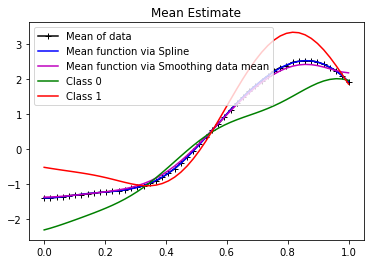

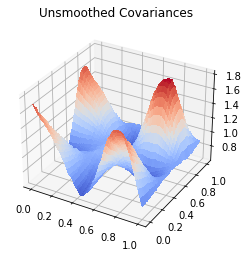

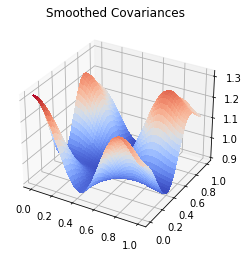

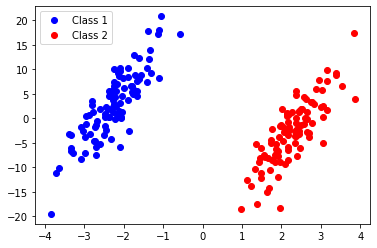

Confusion Matrix - FPCA
          Predicted 0  Predicted 1
Class 0           21            0
Class 1            0           19


In [18]:
# Option 2: Functional principal components
B_stacked = np.tile(B.T, 200).T
X_stacked = X.ravel()
beta = np.linalg.lstsq(B_stacked, X_stacked)[0]
mu_hat = B.dot(beta)  # Mean function via B-Spline
mu_hat2 = gaussian_filter(X.mean(0),3)
plt.plot(x, X.mean(0), 'k+-', label='Mean of data')
plt.plot(x, mu_hat, 'b', label='Mean function via Spline')
plt.plot(x, mu_hat2, 'm', label='Mean function via Smoothing data mean')
plt.plot(x, mean1, 'g', label='Class 0')
plt.plot(x, mean2, 'r', label='Class 1')
plt.legend()
plt.title("Mean Estimate")
plt.show()
diffs = X-mu_hat
Cov = np.cov(diffs.T)
grids = np.meshgrid(x, x)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(grids[0], grids[1], Cov, cmap=cm.coolwarm,
                linewidth=0, antialiased=False)
plt.title('Unsmoothed Covariances')
plt.show()
# additional Cov smoothing:
Cov = gaussian_filter(Cov, sigma=7)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(grids[0], grids[1], Cov, cmap=cm.coolwarm,
                linewidth=0, antialiased=False)
plt.title('Smoothed Covariances')
plt.show()
l, psi = np.linalg.eigh(Cov)
PCs = psi[:, -2:]
FPC_scores = diffs.dot(PCs)
plt.plot(FPC_scores[:M,0],FPC_scores[:M,1],'bo',label='Class 1')
plt.plot(FPC_scores[M:,0],FPC_scores[M:,1],'ro',label='Class 2')
plt.legend()
plt.show()
rf = RandomForestClassifier()
rf.fit(FPC_scores[i_trg, :], Y_trg)
pred = rf.predict(FPC_scores[i_tst, :])
conf = confusion_matrix(Y_tst, pred)
conf = pd.DataFrame(conf, index=['Class 0', 'Class 1'], columns=[
                    'Predicted 0', 'Predicted 1'])
print('Confusion Matrix - FPCA\n', conf)
